In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MS_NEU/7100_TimeSeries/Project/training_features_file.csv')

In [ ]:
df = df.drop('Unnamed: 0', axis = 1)

#Time-series Forecasting Problem
Here we limit our data to only 4 buildings due to computational challenges (high RAM usage).  We predict energy meter values for one time series instance, that is for buildings (105, 162, 255, 257) and a meter type, electricity.

In [ ]:
df_four_buildings = df[ (df['meter'] == 0) & (df['building_id'].isin( [105,162,255,257] )) ]

In [ ]:
df_four_buildings.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekend,is_holiday
0,105,0,2016-01-01 00:00:00,23.3036,1,0,10.832181,3.8,0.0,2.4,0.0,1020.9,240.0,3.1,0,4,1
70,162,0,2016-01-01 00:00:00,68.6200,2,0,11.501156,15.6,6.0,-5.6,0.0,1015.3,270.0,3.6,0,4,1
285,255,0,2016-01-01 00:00:00,24.3500,2,0,10.801187,15.6,6.0,-5.6,0.0,1015.3,270.0,3.6,0,4,1
290,257,0,2016-01-01 00:00:00,43.1500,2,0,11.233886,15.6,6.0,-5.6,0.0,1015.3,270.0,3.6,0,4,1
350,105,0,2016-01-01 01:00:00,45.6071,1,0,10.832181,3.7,0.0,2.4,0.0,1021.6,230.0,2.6,1,4,0


In [ ]:
df_four_buildings.shape

(35133, 17)

In [ ]:
df_four_buildings = df_four_buildings[['building_id',	'meter', 'site_id',	'primary_use',	'square_feet',	'air_temperature'	,'cloud_coverage',	'dew_temperature',	'precip_depth_1_hr',	'sea_level_pressure',	'wind_direction',	'wind_speed',	'hour',	'weekend',	'is_holiday', 'meter_reading']]

#Preprocessing 

In [ ]:
## Dropping redudant columns
df_four_buildings = df_four_buildings.drop(['building_id',	'meter', 	'site_id', 	'primary_use',	'square_feet', 'hour', 'weekend'], axis = 1)

The null values were already resolved in the preprocessing part

In [ ]:
df_four_buildings.isnull().any()

air_temperature       False
cloud_coverage        False
dew_temperature       False
precip_depth_1_hr     False
sea_level_pressure    False
wind_direction        False
wind_speed            False
is_holiday            False
meter_reading         False
dtype: bool

## Data splitting into train and test sets


In [ ]:
# last 0.20% of the dataset is used as the testing set.
splitter = sorted(df_four_buildings.index.values)[-int(0.20*len(df_four_buildings))]
test_lstm_df = df_four_buildings[(df_four_buildings.index >= splitter)]  # make the validation data where the index is in the last 20%
train_lstm_df = df_four_buildings[(df_four_buildings.index < splitter)] 



In [ ]:
test_lstm_df

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_holiday,meter_reading
2973638,29.4,0.000000,5.0,0.0,1013.3,330.0,3.1,0,40.5000
2973643,29.4,0.000000,5.0,0.0,1013.3,330.0,3.1,0,70.9500
2973831,11.3,0.000000,6.5,0.0,1021.6,320.0,2.6,0,89.3768
2973901,31.1,0.000000,5.0,0.0,1012.1,0.0,0.0,0,58.7400
2974117,31.1,0.000000,5.0,0.0,1012.1,0.0,0.0,0,34.3300
...,...,...,...,...,...,...,...,...,...
3813679,16.7,5.666667,10.0,0.0,1011.0,250.0,3.6,0,42.0200
3813868,7.5,0.000000,6.5,0.0,1024.7,210.0,5.7,0,44.2970
3813938,16.7,5.666667,10.0,0.0,1011.0,250.0,2.6,0,53.2500
3814153,16.7,5.666667,10.0,0.0,1011.0,250.0,2.6,0,26.3300


In [ ]:
train_lstm_df

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_holiday,meter_reading
0,3.8,0.0,2.4,0.0,1020.9,240.000000,3.1,1,23.3036
70,15.6,6.0,-5.6,0.0,1015.3,270.000000,3.6,1,68.6200
285,15.6,6.0,-5.6,0.0,1015.3,270.000000,3.6,1,24.3500
290,15.6,6.0,-5.6,0.0,1015.3,270.000000,3.6,1,43.1500
350,3.7,0.0,2.4,0.0,1021.6,230.000000,2.6,0,45.6071
...,...,...,...,...,...,...,...,...,...
2972943,29.4,0.0,3.9,0.0,1013.6,94.347826,2.1,0,58.4600
2973159,29.4,0.0,3.9,0.0,1013.6,94.347826,2.1,0,43.6100
2973164,29.4,0.0,3.9,0.0,1013.6,94.347826,2.1,0,76.9600
2973352,12.1,0.0,6.8,0.0,1021.5,330.000000,2.6,0,89.3768


## Time series visualization

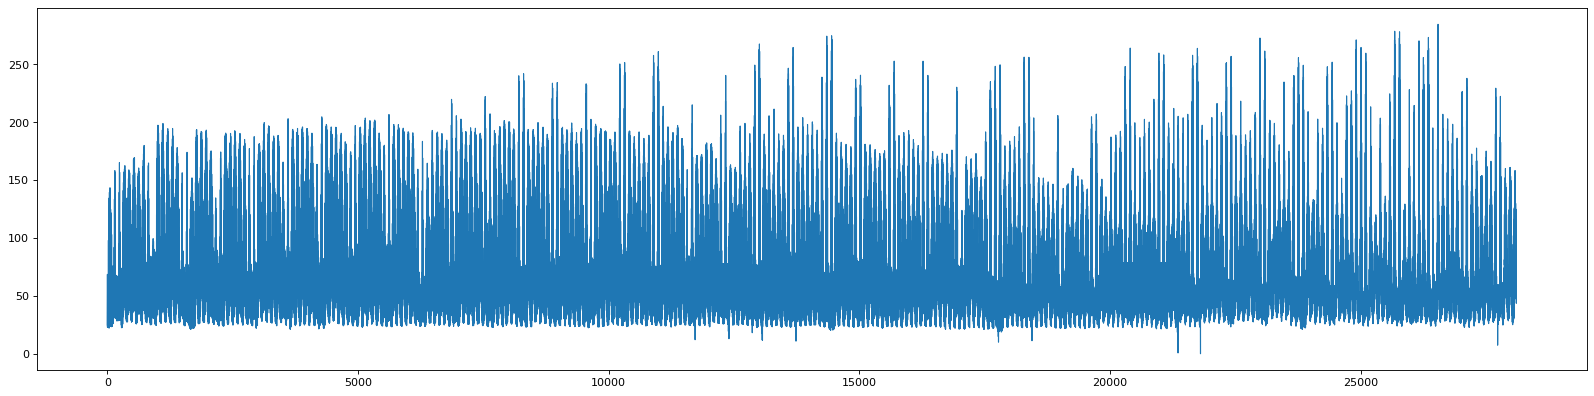

In [ ]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
from collections import deque
import numpy as np
import random

x = np.array([i for i in range(len(train_lstm_df))])
y = train_lstm_df['meter_reading']
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x,y, linewidth=1)
plt.show()

###Scaling and sequencing of training data by windowing method

In [ ]:
# Scaling 

SEQ_LEN = 10

for col in train_lstm_df.columns:  # go through all of the columns
    if col not in ["meter_reading", "is_holiday"]:
        #df[col] = df[col].pct_change() 
        train_lstm_df[col] = preprocessing.scale(train_lstm_df[col].values)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
sequential_data = [] 
prev_days = deque(maxlen=SEQ_LEN) 

for i in train_lstm_df.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == SEQ_LEN:
        sequential_data.append([np.array(prev_days), i[-1]])

In [ ]:
X = []
y = []

for seq, target in sequential_data:  # going over our new sequential data
    X.append(seq)  # X is the sequences
    y.append(target)

In [ ]:
train_x = np.asarray(X)
train_y = np.asarray(y)
train_y = np.log1p(train_y) #Log-tranformation of target variable

In [ ]:
train_y.shape

(28098,)

In [ ]:
train_y

array([4.20260088, 3.20842137, 3.78441688, ..., 4.35619587, 4.5039876 ,
       4.09167433])

In [ ]:
len(train_y)

28098

###Scaling and sequencing of testing data by windowing method

In [ ]:
for col in test_lstm_df.columns:  # go through all of the columns
    if col not in ["meter_reading", "is_holiday"]:
        #df[col] = df[col].pct_change() 
        #df.dropna(inplace=True)
        test_lstm_df[col] = preprocessing.scale(test_lstm_df[col].values)


    #df.dropna(inplace=True)

sequential_data = [] 
prev_days = deque(maxlen=SEQ_LEN) 

for i in test_lstm_df.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == SEQ_LEN:
        sequential_data.append([np.array(prev_days), i[-1]])

#random.shuffle(sequential_data)

X = []
y = []

for seq, target in sequential_data:  # going over our new sequential data
    X.append(seq)  # X is the sequences
    y.append(target)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
test_x = np.asarray(X)
test_y = np.asarray(y)
test_y = np.log1p(test_y)

In [ ]:
test_x.shape

(7017, 10, 8)

## LSTM model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
batch_size = 64


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1))

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0005, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer= opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_x, train_y, epochs= 25, batch_size= batch_size, validation_data=(test_x, test_y),)

Epoch 1/25
440/440 [==============================] - 16s 13ms/step - loss: 2.6222 - val_loss: 0.3516
Epoch 2/25
440/440 [==============================] - 5s 11ms/step - loss: 0.9457 - val_loss: 0.2868
Epoch 3/25
440/440 [==============================] - 5s 11ms/step - loss: 0.8253 - val_loss: 0.2719
Epoch 4/25
440/440 [==============================] - 5s 11ms/step - loss: 0.7290 - val_loss: 0.3106
Epoch 5/25
440/440 [==============================] - 6s 14ms/step - loss: 0.6400 - val_loss: 0.2822
Epoch 6/25
440/440 [==============================] - 5s 12ms/step - loss: 0.5765 - val_loss: 0.2427
Epoch 7/25
440/440 [==============================] - 5s 11ms/step - loss: 0.5037 - val_loss: 0.2442
Epoch 8/25
440/440 [==============================] - 5s 11ms/step - loss: 0.4423 - val_loss: 0.2694
Epoch 9/25
440/440 [==============================] - 5s 11ms/step - loss: 0.3753 - val_loss: 0.1996
Epoch 10/25
440/440 [==============================] - 5s 11ms/step - loss: 0.3271 - val_l

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           70144     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 10, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 10, 128)          512       
 hNormalization)                                        

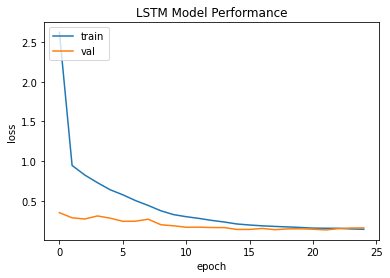

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

In [ ]:
trainPredict[:,0]

array([4.3216705, 3.4497151, 3.8685932, ..., 3.9035106, 4.405718 ,
       4.598858 ], dtype=float32)

### Performance Evaluation

In [ ]:
# plot series
def plot_series(data, plot_name,title_name):
    plt.plot( data, color="blue", linewidth = 2,label='series')
    plt.title(title_name)
    plt.xlabel('Time',fontsize=10)
    plt.ylabel('Y',fontsize=10)
    plt.legend(fontsize=10)
    plt.savefig(plot_name)

    plt.show()
    

# plot for actual versus prediction results
def plot_actual_vs_pred( plot_name, y_test, y_pred): #test_start_index  
    plt.plot( y_test, color="blue", linewidth=3,label='Actual')
    plt.plot( y_pred, color="green", linewidth=3,label='Prediction')
    plt.xlabel('Time',fontsize=10)
    plt.ylabel('Y',fontsize=10)
    plt.legend(fontsize=10)
    plt.savefig(plot_name)

    plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

(7017, 10, 8)


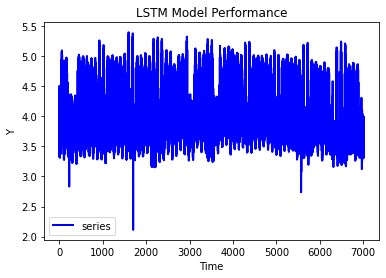

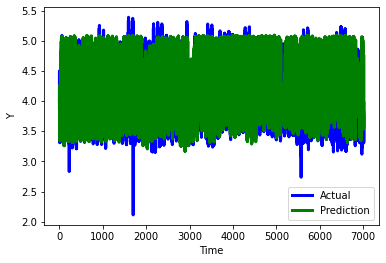

In [ ]:
plot_name = "LSTM_actual_vs_pred.png"
title_name = "LSTM Model Performance"
print(test_x.shape)
plot_series(test_y, plot_name, title_name)
plot_actual_vs_pred( plot_name, test_y, testPredict)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
mse =mean_squared_error(test_y, testPredict[:,0])
print('Test Score: %.2f MSE' % (mse))
mae = mean_absolute_error(test_y,testPredict[:,0])
print('Test Score: %.2f MAE' % (mae))
r2 = r2_score(test_y, testPredict[:,0])
print('R2 score' , r2)

Test Score: 0.16 MSE
Test Score: 0.29 MAE
R2 score 0.22981110690951434
